In [3]:
# Generate Multiline Vector from Labelbox Labels

from glob import glob
import pandas as pd
import json
import rasterio as rio
from shapely.geometry import LineString
from shapely.geometry import Polygon
from geopandas import GeoDataFrame
import geopandas
from shapely.ops import transform
from functools import partial
import pyproj
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Extract Chips

import gdal
import os

In [4]:
def add_trailing_slash(path):
    if path[-1] != '/':
        path += '/'
    return path

# Sum Length of Vectors

In [3]:
file = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/GEE/vectors/all_vectors/ISL/1/1_ISL.shp"

gdf = geopandas.read_file(file)

In [4]:
sample_line = gdf.loc[0]['geometry']

In [5]:
def line_length(shapefile):
    
    # Geometry transform function based on pyproj.transform
    project = partial(
        pyproj.transform,
        pyproj.Proj('EPSG:4326'),
        pyproj.Proj('EPSG:32633'))
    
    gdf = geopandas.read_file(file)
    
    line_sum = 0
    
    for geo in gdf["geometry"]:

        line2 = transform(project, geo)
        
        meter_length = line2.length
        
        line_sum += meter_length
        
    return line_sum

In [6]:
line_length(file)

63115.801088527696

In [13]:
def line_label_sums(vector_path,line_labels):
    
    vector_path = add_trailing_slash(vector_path)
    
    line_label_sums = {}
    
    for label in line_labels:
    
        vector_list = glob(f'{vector_path}/{label}/*/*.shp')
        
        geo_lengths = [line_length(i) for i in vector_list]
            
        line_label_sums[label] = sum(geo_lengths)
        
    return line_label_sums
    
    
    
vector_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/GEE/vectors/all_vectors"
line_labels = ["ISL","Roads","River"]

In [14]:
sum_dict = line_label_sums(vector_path,line_labels)

label_not_there
label_not_there
label_not_there


In [15]:
sum_dict

{'ISL': 3850063.8664001925,
 'Roads': 2145937.2370099425,
 'River': 1704126.6293902483}

In [116]:
pd.options.display.float_format = '{:,}'.format

In [117]:
sum_dict2 = sum_dict.copy()

In [118]:
for key in sum_dict2.keys():
    sum_dict2[key] = sum_dict2[key] / 1000

In [119]:
sum_dict2

{'ISL': 3850.0638664001926,
 'Roads': 2145.9372370099427,
 'River': 1704.1266293902484}

In [120]:
df = pd.DataFrame(sum_dict2,index=[0])

In [124]:
df.round()

,ISL,Roads,River
0,"3,850.0","2,146.0","1,704.0"


In [122]:
df2 = df.astype(int)

In [123]:
df2

,ISL,Roads,River
0,3850,2145,1704


In [101]:
df2 = df2.astype(str)

In [102]:
for column in df2:
    df2[column] = df2[column] + " " + "km"

In [112]:
df2

,ISL,Roads,River
0,3850 km,2145 km,1704 km


# Chips Per Size / Class

In [155]:
def chips_size_class(input_dir):
    
    chips = {}
    
    input_dir = add_trailing_slash(input_dir)
    
    chip_path_label = glob(f'{input_dir}/*/')
    
    for label_path in chip_path_label:
        
        label = label_path.split("/")[-2]
        
        chips[label] = {} 

        chip_path_size = glob(f'{label_path}/*/')
        
        for size_path in chip_path_size:
            
            size = size_path.split("/")[-2]
                
            chip_path_label_size = glob(f'{size_path}/*/*.tif')
                                        
            tif_len = len(chip_path_label_size)
                                        
            chips[label][size] = tif_len
                                        
            
                
    return chips
            

        
    
    
#     sizes = [100,200,1000]
#     labels = []

In [157]:
input_dir = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Chips/misha_polygons_v8/yes"

chips_count = chips_size_class(input_dir)

In [163]:
chips_df = pd.DataFrame(chips_count)

In [167]:
chips_df

,ISL,Habitation,Shifting_cultivation,Mining,Rainforest,Savannah,Water,River,Roads,Industrial_agriculture
100,6791,775,3852,220,24489,4034,1825,2570,1445,1450
200,2802,418,1342,95,7234,1164,499,1027,716,448
1000,299,94,141,15,572,83,31,147,134,45


<AxesSubplot:>

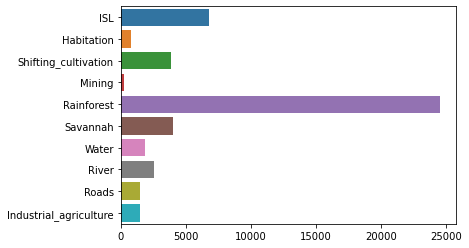

In [170]:
# ax = sns.barplot(x="tip", y="day", data=chips_df)

sns.barplot(data=chips_df.head(1), orient = 'h')

In [186]:
chips_df_2 = chips_df.reset_index()

In [189]:
chips_df_3 = chips_df_2.rename(columns={"index":"size"})

In [294]:
chips_df_3

,size,ISL,Habitation,Shifting_cultivation,Mining,Rainforest,Savannah,Water,River,Roads,Industrial_agriculture
0,100,6791,775,3852,220,24489,4034,1825,2570,1445,1450
1,200,2802,418,1342,95,7234,1164,499,1027,716,448
2,1000,299,94,141,15,572,83,31,147,134,45


In [313]:
# chips_df.melt('date', var_name='a', value_name='b')

chips_df_4 = pd.melt(chips_df_3, id_vars=["size"], value_vars=list(chips_df_3.columns[1:]))

In [314]:
chips_df_4["size"] = chips_df_4["size"].replace({"100": "1 km\u00b2", "200": "4 km\u00b2","1000": "100 km\u00b2"})

In [315]:
chips_df_4.head(3)

,size,variable,value
0,1 km²,ISL,6791
1,4 km²,ISL,2802
2,100 km²,ISL,299


In [316]:
chips_df_5 = chips_df_4.rename(columns={"size": "Chip Size", "variable": "Label", "value":"Number of Chips"})

In [317]:
chips_df_5

,Chip Size,Label,Number of Chips
0,1 km²,ISL,6791
1,4 km²,ISL,2802
2,100 km²,ISL,299
3,1 km²,Habitation,775
4,4 km²,Habitation,418
5,100 km²,Habitation,94
6,1 km²,Shifting_cultivation,3852
7,4 km²,Shifting_cultivation,1342
8,100 km²,Shifting_cultivation,141
9,1 km²,Mining,220


In [335]:
chip_arr = []
for row in chips_df_5.iterrows():
    chip_size = row[1]["Chip Size"]
    chip_size = int(chip_size.split(" ")[0])
    chip_area = row[1]["Number of Chips"] * chip_size
    chip_area = str("{:,}".format(chip_area)) + " " + "km\u00b2"
    chip_arr.append(chip_area)

chips_df_5["Total Area"] = chip_arr

In [346]:
sizes = ["1","4","100"]
area_for_graph = []
for i in sizes:
    for row in chips_df_5.iterrows():
        if i == row[1]["Chip Size"].split(" ")[0]:
            area_for_graph.append(row[1]["Total Area"])

print(area_for_graph)            

['6,791 km²', '775 km²', '3,852 km²', '220 km²', '24,489 km²', '4,034 km²', '1,825 km²', '2,570 km²', '1,445 km²', '1,450 km²', '11,208 km²', '1,672 km²', '5,368 km²', '380 km²', '28,936 km²', '4,656 km²', '1,996 km²', '4,108 km²', '2,864 km²', '1,792 km²', '29,900 km²', '9,400 km²', '14,100 km²', '1,500 km²', '57,200 km²', '8,300 km²', '3,100 km²', '14,700 km²', '13,400 km²', '4,500 km²']


In [336]:
chips_df_5

,Chip Size,Label,Number of Chips,Total Area
0,1 km²,ISL,6791,"6,791 km²"
1,4 km²,ISL,2802,"11,208 km²"
2,100 km²,ISL,299,"29,900 km²"
3,1 km²,Habitation,775,775 km²
4,4 km²,Habitation,418,"1,672 km²"
5,100 km²,Habitation,94,"9,400 km²"
6,1 km²,Shifting_cultivation,3852,"3,852 km²"
7,4 km²,Shifting_cultivation,1342,"5,368 km²"
8,100 km²,Shifting_cultivation,141,"14,100 km²"
9,1 km²,Mining,220,220 km²


In [340]:
chips_df_5["Total Area"].loc[0]

'6,791 km²'

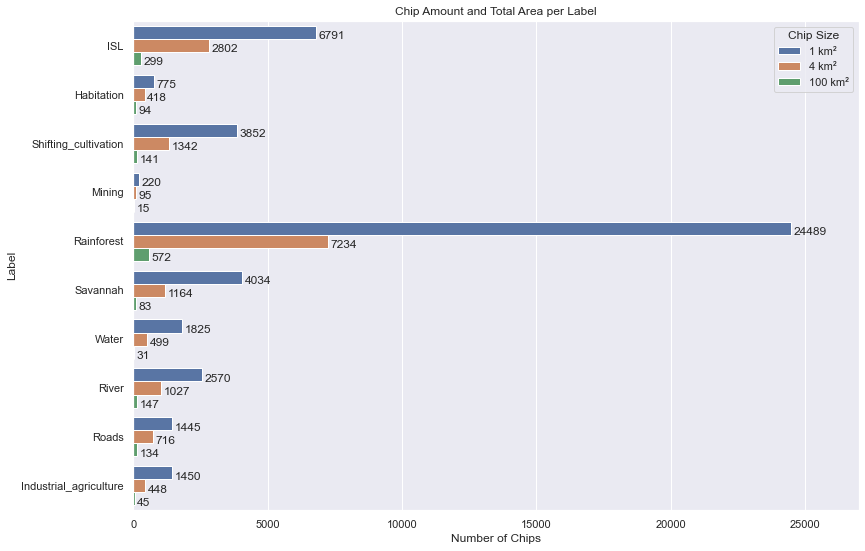

In [358]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(13,9)})
ax = sns.barplot(x='Number of Chips', y='Label', hue='Chip Size',data=chips_df_5)

for p in ax.patches:
    _x = p.get_x() + p.get_width() + float(100)
    _y = p.get_y() + p.get_height()
    value = int(p.get_width())
    ax.text(_x, _y, value, ha="left")
    
    
ax.set_title('Chip Amount and Total Area per Label')
ax.set_xlim(0,27000)






plt.show()

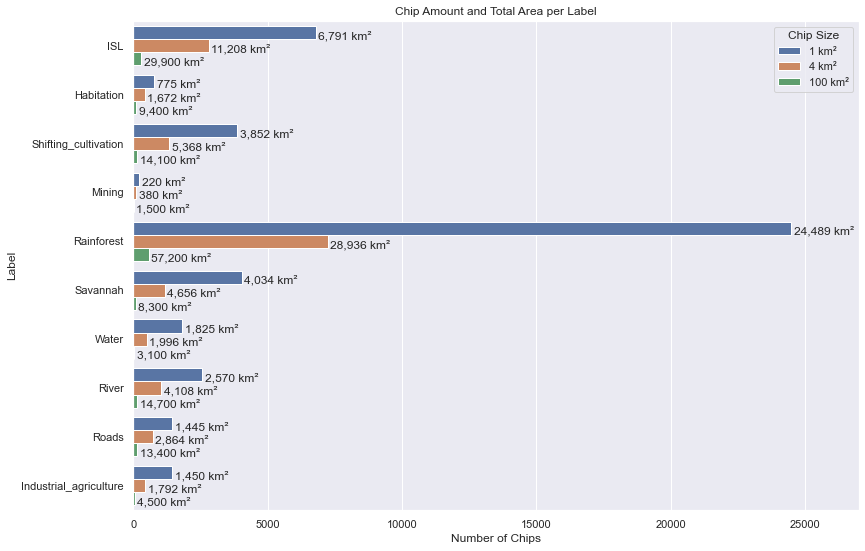

In [357]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(13,9)})
ax = sns.barplot(x='Number of Chips', y='Label', hue='Chip Size',data=chips_df_5)

for index,p in enumerate(ax.patches):
    _x = p.get_x() + p.get_width() + float(100)
    _y = p.get_y() + p.get_height()
    value = area_for_graph[index]
#     print(value)
#     value = int(p.get_width())
    ax.text(_x, _y, value, ha="left")
    
    
ax.set_title('Chip Amount and Total Area per Label')
ax.set_xlim(0,27000)






plt.show()

In [262]:
help(ax.annotate)

Help on method annotate in module matplotlib.axes._axes:

annotate(text, xy, *args, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Annotate the point *xy* with text *text*.
    
    In the simplest form, the text is placed at *xy*.
    
    Optionally, the text can be displayed in another position *xytext*.
    An arrow pointing from the text to the annotated point *xy* can then
    be added by defining *arrowprops*.
    
    Parameters
    ----------
    text : str
        The text of the annotation.  *s* is a deprecated synonym for this
        parameter.
    
    xy : (float, float)
        The point *(x, y)* to annotate. The coordinate system is determined
        by *xycoords*.
    
    xytext : (float, float), default: *xy*
        The position *(x, y)* to place the text at. The coordinate system
        is determined by *textcoords*.
    
    xycoords : str or `.Artist` or `.Transform` or callable or (float, float), default: 'data'
    
        The coordi

In [247]:
def show_values_on_bars(axs, h_v="h", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
    plt.show()
        
        
        
        
show_values_on_bars(ax,h_v="h",space=0.4)

# Line Length of OSM Logging Road Dataset

In [42]:
file = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Geometry/osm_logging_roads/osm_logging_roads.shp"
gdf = geopandas.read_file(file)

In [6]:
def line_length(gdf):
    
    # Geometry transform function based on pyproj.transform
    project = partial(
        pyproj.transform,
        pyproj.Proj('EPSG:3857'),
        pyproj.Proj('EPSG:32633'))
    
    line_sum = 0
    
    for index,geo in enumerate(gdf["geometry"],1):
        
        print(f'Summing line {index} of {gdf.shape[0]}. Current sum: {line_sum}', end='\r', flush=True)

#         line2 = transform(project, geo)
        
#         meter_length = line2.length
        
        meter_length = geo.length

        line_sum += meter_length
        
    return line_sum

In [7]:
line_length(gdf)

344822970.2993504

In [48]:
gdf2 = gdf.copy()

In [63]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
gdf2["start_date"].value_counts()

before 2000          2397
before 2008           875
2010                  650
2014                  535
before 2004           333
2006                  314
before 2006           295
2012                  225
before 2012           223
before 2007           194
2008                  183
2002                  179
before 2001-02-14     177
2001                  160
2011                  160
2007                  158
2013                  156
before 1999-12-08     130
before 2001-04-26     117
before 2014           113
2005                  111
2009                  110
after 2013            103
1986                   98
before 2003            94
before 2009-03-26      81
2003                   80
2004                   77
before 2012-08-22      69
2000                   58
before 2001-03-18      52
before 2007-03-10      51
before 2000-03-24      49
1990                   48
befor 2000             46
before 2002-12-27      45
before 2002-01-16      44
before 2008-05-10      43
1998        

In [65]:
gdf2.columns

Index(['osm_id', 'access', 'bridge', 'end_date', 'ferry', 'ford', 'highway',
       'informal', 'maxspeed', 'name', 'oneway', 'opening_ho', 'operator',
       'ref', 'route', 'seasonal', 'smoothness', 'source', 'start_date',
       'surface', 'trail_visi', 'tunnel', 'width', 'st_length_', 'geometry'],
      dtype='object')

In [64]:
# gdf2[gdf2["start_date"] == "None"]

gdf2[gdf2["start_date"].isna()]

# gdf2.head(10)

,osm_id,access,bridge,end_date,ferry,ford,highway,informal,maxspeed,name,oneway,opening_ho,operator,ref,route,seasonal,smoothness,source,start_date,surface,trail_visi,tunnel,width,st_length_,geometry
0,410232482,None,None,None,None,None,path,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,52.126344,"LINESTRING (2429282.022 767645.622, 2429254.84..."
1,410056961,None,None,None,None,None,path,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,847.180207,"LINESTRING (2422028.945 771377.947, 2422044.16..."
2,410083224,None,None,None,None,None,path,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,199.314437,"LINESTRING (2427727.245 770202.195, 2427722.99..."
3,410083243,None,None,None,None,None,path,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,166.946792,"LINESTRING (2428646.154 771393.893, 2428653.35..."
4,410232463,None,None,None,None,None,path,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,237.446886,"LINESTRING (2429549.757 767994.191, 2429558.61..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260821,391332555,None,None,None,None,None,path,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,887.770820,"LINESTRING (1601059.589 731516.646, 1601098.19..."
260822,391354744,None,None,None,None,None,unclassified,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,129.005963,"LINESTRING (1595344.480 735883.478, 1595320.34..."
260823,391366794,None,None,None,None,None,unclassified,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,626.730165,"LINESTRING (1595543.497 742636.947, 1595601.13..."
260824,391366805,None,None,None,None,None,path,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,27.695708,"LINESTRING (1596605.084 742898.429, 1596599.93..."


In [34]:
gdf["start_date"] = gdf["start_date"].replace(np.nan, '', regex=True).value_counts()

In [38]:
years = ["2013","2012","2014"]

# gdf["start_date"].replace()

# gdf["start_date"].astype("object")



# gdf[gdf["start_date"].str.contains(years[0])] 



0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
260821    NaN
260822    NaN
260823    NaN
260824    NaN
260825    NaN
Name: start_date, Length: 260826, dtype: object

In [40]:
gdf["start_date"].value_counts()

Series([], Name: start_date, dtype: int64)